In [46]:

import time
import torch
import numpy as np
from utils import *
from tqdm import trange
from NetworkPaul import *
import torch.optim as optim
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib as mpl


# Load S
S = np.load("Data/seismic_diffusion_11.npy")
S = torch.from_numpy(S)
S = S-S.min()
S = S/S.max()
S = S*2 - 1
S = S.to(device)

print('Maximum value of S', S.max())
print('Minimum value of S', S.min())

T1, M1 = uniform_sampling(S, 50)
T1 = T1.to(device)
M1 = M1.to(device)

batch_size = 10
dataset = dataset = SeismicDataset(T1, S, M1)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

network = AttU_Net(img_ch=10,output_ch=10).to(device)

binary_layer = MaskLayer((1024,128)).to(device)
reg =  SubsamplingRate(parameter=1, compression=0.9)  

optimizer = optim.Adam(list(network.parameters()) + list(binary_layer.parameters()), lr=1e-3)
criterion = nn.MSELoss()

start = time.time()

epochs = 100

list_loss1, list_loss2, list_loss3, list_loss_total = [], [], [], []

for epoch in trange(epochs, desc="Entrenamiento"):
    network.train()
    binary_layer.train()
    
    for batch_T1, batch_S, batch_M1 in dataloader:
        batch_T1 = batch_T1.to(device)
        batch_S = batch_S.to(device)
        batch_M1 = batch_M1.to(device)

        optimizer.zero_grad()
        
        M2 = binary_layer(batch_T1)
        M2 = M2*(1-batch_M1)
        T2 = M2*batch_S
        
        first_term = M2*network(batch_T1)
        second_term = T2

        loss1 = criterion(first_term, second_term)
        
        distance_m1, distance_m2 = binary_distance(batch_M1, M2)
        break
    break

Maximum value of S tensor(1.)
Minimum value of S tensor(-1.)


Entrenamiento:   0%|          | 0/100 [00:00<?, ?it/s]

Columnas removidas: 51


Entrenamiento:   0%|          | 0/100 [00:14<?, ?it/s]


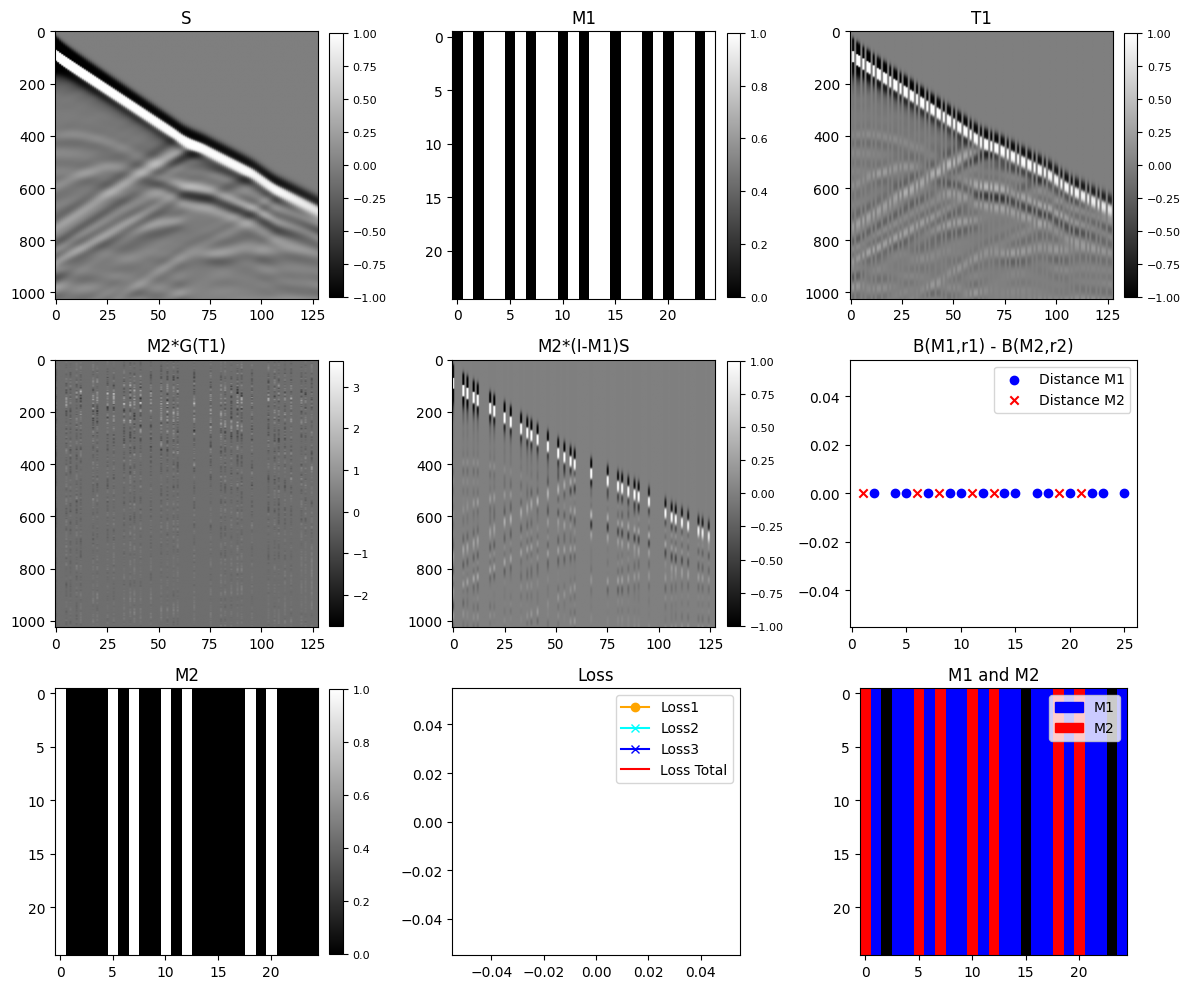

In [59]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(3, 3, figsize=(12, 10))

def imshow_with_colorbar(ax, data, title):
    im = ax.imshow(data, aspect='auto', cmap='gray')
    ax.set_title(title)
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)

# Usar primer elemento del batch
b0 = 0
imshow_with_colorbar(ax[0, 0], batch_S[b0, 0].cpu().numpy(), 'S')
imshow_with_colorbar(ax[0, 1], batch_M1[b0, 0, :25, :25].cpu().numpy(), 'M1')
imshow_with_colorbar(ax[0, 2], batch_T1[b0, 0].cpu().numpy(), 'T1')
imshow_with_colorbar(ax[1, 0], first_term[b0, 0].detach().cpu().numpy(), 'M2*G(T1)')
imshow_with_colorbar(ax[1, 1], second_term[b0, 0].detach().cpu().numpy(), 'M2*(I-M1)S')
imshow_with_colorbar(ax[2, 0], M2[b0, 0, :25, :25].detach().cpu().numpy(), 'M2')

x1 = distance_m1.detach().cpu()[:25]
x2 = distance_m2.detach().cpu()[:25]

x1_nonzero = x1[x1 != 0]
x2_nonzero = x2[x2 != 0]

y1 = np.zeros_like(x1_nonzero)
y2 = np.zeros_like(x2_nonzero)

# Distancia entre máscaras
ax[1, 2].scatter(x1_nonzero,y1, label='Distance M1', marker='o', color='blue')
ax[1, 2].scatter(x2_nonzero,y2, label='Distance M2', marker='x', color='red')
#ax[1, 2].plot(abs(distance_m1.detach().cpu() - distance_m2.detach().cpu()), color='purple', label='|Dist M1 - M2|')
ax[1, 2].set_title('B(M1,r1) - B(M2,r2)')
ax[1, 2].legend()

# Gráfico de pérdidas
ax[2, 1].plot(list_loss1, marker='o', color='orange', label='Loss1')
ax[2, 1].plot(list_loss2, marker='x', color='cyan', label='Loss2')
ax[2, 1].plot(list_loss3, marker='x', color='blue', label='Loss3')
ax[2, 1].plot(list_loss_total, linestyle='-', color='red', label='Loss Total')
ax[2, 1].set_title('Loss')
ax[2, 1].legend()

mask1 = batch_M1[b0, 0, :25, :25].cpu().numpy()
mask2 = M2[b0, 0, :25, :25].detach().cpu().numpy()

# Máscaras para visualización: solo los unos visibles
mask1_vis = np.ma.masked_where(mask1 == 0, mask1)
mask2_vis = np.ma.masked_where(mask2 == 0, mask2)

# Colormaps personalizados (puedes ajustar los colores si lo deseas)
cm1 = mpl.colors.ListedColormap(['blue', 'black'])    # M1 en rojo
cm2 = mpl.colors.ListedColormap(['red', 'black'])  # M2 en verde

# Fondo negro
ax[2, 2].set_title('M1 and M2')
ax[2, 2].imshow(np.zeros_like(mask1), cmap='gray', interpolation='nearest')
# M1 en rojo semi-transparente
ax[2, 2].imshow(mask1_vis, cmap=cm1, interpolation='nearest')
# M2 en verde semi-transparente
ax[2, 2].imshow(mask2_vis, cmap=cm2, interpolation='nearest')

blue_patch = mpatches.Patch(color='blue', label='M1')
red_patch = mpatches.Patch(color='red', label='M2') 
ax[2, 2].legend(handles=[blue_patch, red_patch], loc='upper right')


plt.tight_layout()
plt.show(fig)
plt.close(fig)

In [ ]:
receivers_coordinates = torch.arange(1,129)


torch.Size([128])